# Three states MIS algorithm

After simulating a guess algorithm for a 2 level rydberg atom system trying to solve MIS with adiabatic quantum computing

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
# The library for quantum adiabatic simulations.
from qutip import * 
from scipy import *
# The library used for the graph representation.  
import networkx as nx
from guess_algorithm_helper import *
from random import randint
import ipynb.fs.defs.guess_algorithm as algo

and follow up complexity testing compared to classical algorithms

In [6]:
import ipynb.fs.defs.guess_algorithm_tester as tester

We got mixed results. When the guess was close to the expected results, the guess did amazing and we saw huge improvement. 
However, when the guess wasn't as close, as expected the normal algorithm which starts with a ground state for all atoms did better. 

Hence, we want to implement Luby's algorithm, which uses degree based guesses and is one of the best MIS solvers in classical algorithms. Meaning that our goal is implementing something like:
$$|\psi_0 \rangle=\sqrt{\frac{1}{dv}} |r \rangle + \sqrt{1-\frac{1}{dv}} |g \rangle$$

Which would be great, but is also impossible. That is because this will have a probability of neighboring vertexs being in Rydberg states.
To solve that, we will attempt to create a three level system. In the beginning we will only have states at $|0 \rangle$ and $|1 \rangle$. where $|1 \rangle$ is choosing the vertex and $|0 \rangle$ is not choosing the vertex. Meaning that 
$$|\psi_0 \rangle=\sqrt{\frac{1}{dv}} |1 \rangle + \sqrt{1-\frac{1}{dv}} |0 \rangle$$
 
Just like we wanted. And the starting hamiltonain will also reflect that. After some time, using some rabi frequency $\Omega(t)$, we will move as many atoms as possible from $|1 \rangle$ to $|r \rangle$. Which can be looked as as the original 2 states algorithm with $|1 \rangle$ being the ground. 

Since at the start the rydberg state probability is 0, all initial states will be viable ground states without any need for $H_0$ to be implemented at the start of the run.Hence we get:

$$\begin{cases}
H_0 = \sum_{n=1}^NI - \sigma_{x_{1,r}} ^n \\
H_p = -\Delta n_v \\
H_{int} = \sum_{v<w}V/x^6(|\vec{x}_v-\vec{x}_w|)n_vn_w
\end{cases}
$$

With 
$$\sigma_{x_{1,r}} = \begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 1 \\
0 & 1 & 0
\end{pmatrix}$$

Using that we can build a full hamiltonian:
$$H_{tot} = H_0 \Omega(t) + H_p\Delta(t) + H_{int}$$

In [7]:
from qutip import qeye, basis, Qobj, tensor, sigmaz

class LubyHamiltonian(algo.BaseHamiltonian):
    def __init__(self, params, graph_instance):
        """
        Initializes the Hamiltonian base class with system parameters and graph information.

        Args:
        params (dict): Dictionary of system parameters.
        graph_instance (Graph): Instance of a graph representing the system.
        """
        self.params = params
        self.graph = graph_instance.graph
        self.N = len(self.graph.nodes)
        self.sx_list_0,self.sx_list_1, self.sz_list, self.one_list, self.I_N = self.generate_operators()
    def generate_operators(self):
        """
        Generates useful quantum operators for a system of N states, including a custom sigma_x operator.

        Parameters:
        N (int): The number of operators to generate.
        num_states (int): The dimension of the Hilbert space for each state (e.g., 2 for qubits, 3 for qutrits).

        Returns:
        tuple: A tuple containing lists of tensor products of generalized operators.
            (sx_list, sz_list, one_list, I_N)
        """
        # Identity operator for the specified number of states
        si = qeye(3)


        # Custom σ_x operator for states |0> and |2>, converted to Qobj
        sx_custom_0 = Qobj([[0, 0, 1],
                        [0, 0, 0],
                        [0, 1, 0]])


        # Custom σ_x operator for states |1> and |2>, converted to Qobj
        sx_custom_1 = Qobj([[0, 0, 0],
                        [0, 0, 1],
                        [0, 1, 0]])

        # Initialize empty lists for storing operators
        sx_list_1 = []
        sx_list_0 = []
        sz_list = []
        one_list = []

        # Identity tensor for N states
        I_N = tensor([si] * self.N)

        # Generate the operators
        for n in range(self.N):
            # Initialize a list of identities for the tensor product
            op_list = [si] * self.N

            op_list[n] = sx_custom_0
            sx_list_0.append(tensor(op_list))
            # Replace the n-th position with the custom sx operator
            op_list[n] = sx_custom_1
            sx_list_1.append(tensor(op_list))

            # Replace the n-th position with the sz operator
            sz = Qobj(sigmaz().full()[:3, :3])  # Define sz for the 3-state system
            op_list[n] = sz
            sz_list.append(tensor(op_list))

            # Replace the n-th position with |1><1|
            one = basis(3, 2)  # |1><1| in higher dimensions
            op_list[n] = one * one.dag()
            one_list.append(tensor(op_list))

        return sx_list_0,sx_list_1, sz_list, one_list, I_N

    def create_hamiltonian(self):
        # Base class already calculates the interaction Hamiltonian (H_int)
        H_int = self.create_interaction_term()

        # Specific terms for this Hamiltonian
        CL_H0 = self.I_N - sum(self.sx_list_1)  # Example term for the Hamiltonian
        CL_H1 = self.I_N - sum(self.sx_list_0)  # Example term for the Hamiltonian
        Hp = -sum(self.one_list)  # Example term for the Hamiltonian

        # Return the Hamiltonian in the required format
        return [[1.5*CL_H0, self.params['Omega']], [Hp, self.params['Delta']], H_int]
    
    def initialize_state(self):
        guesses = [(np.sqrt(1/self.graph.degree[n]))*basis(3, 1) +  (np.sqrt(1-1/self.graph.degree[n]))*basis(3, 0) for n in range(self.N)]
        return qutip.tensor(guesses)



## Testing the algorithm

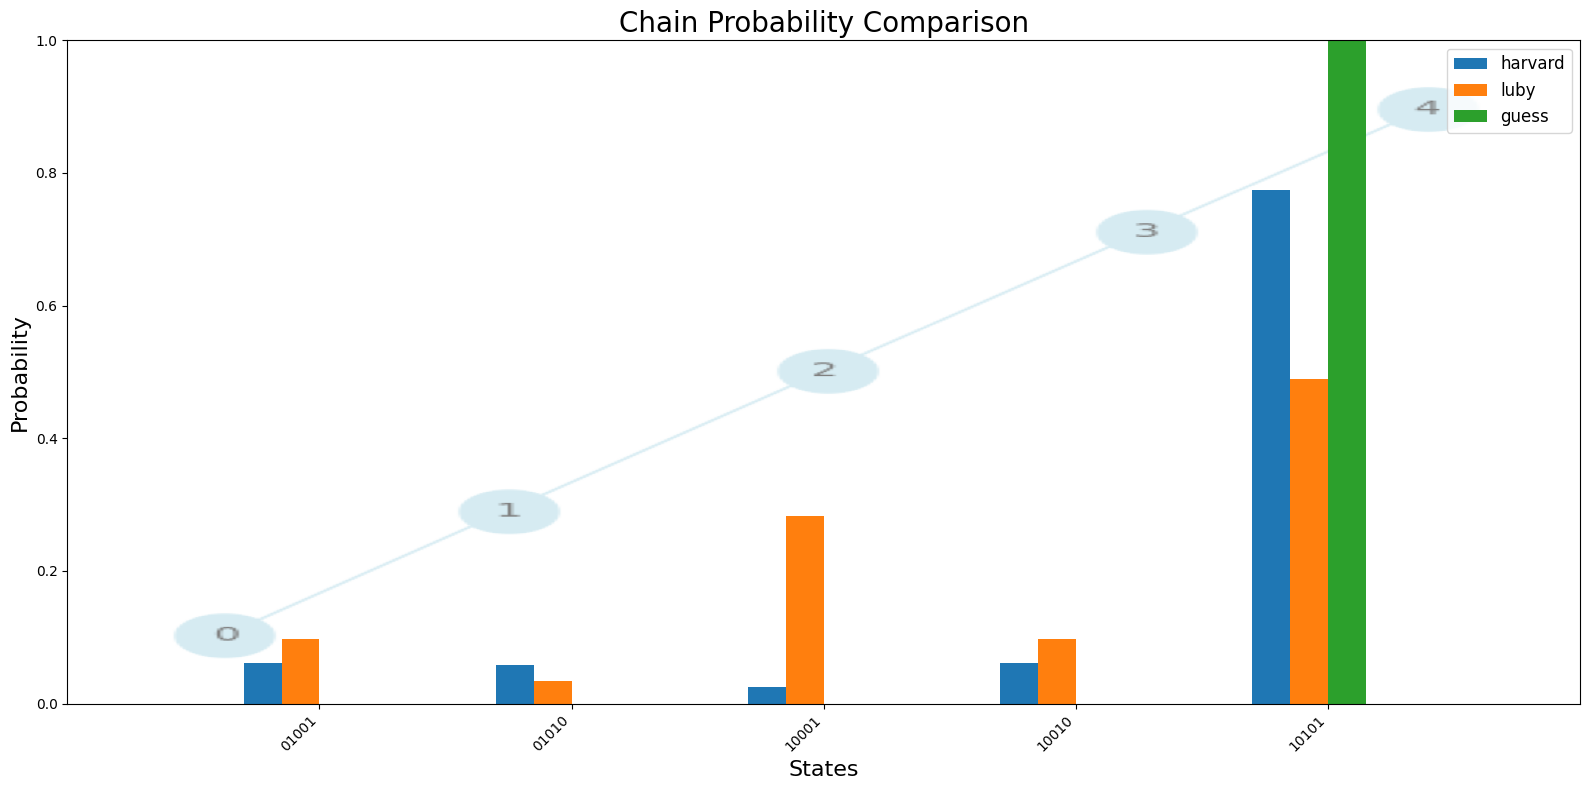

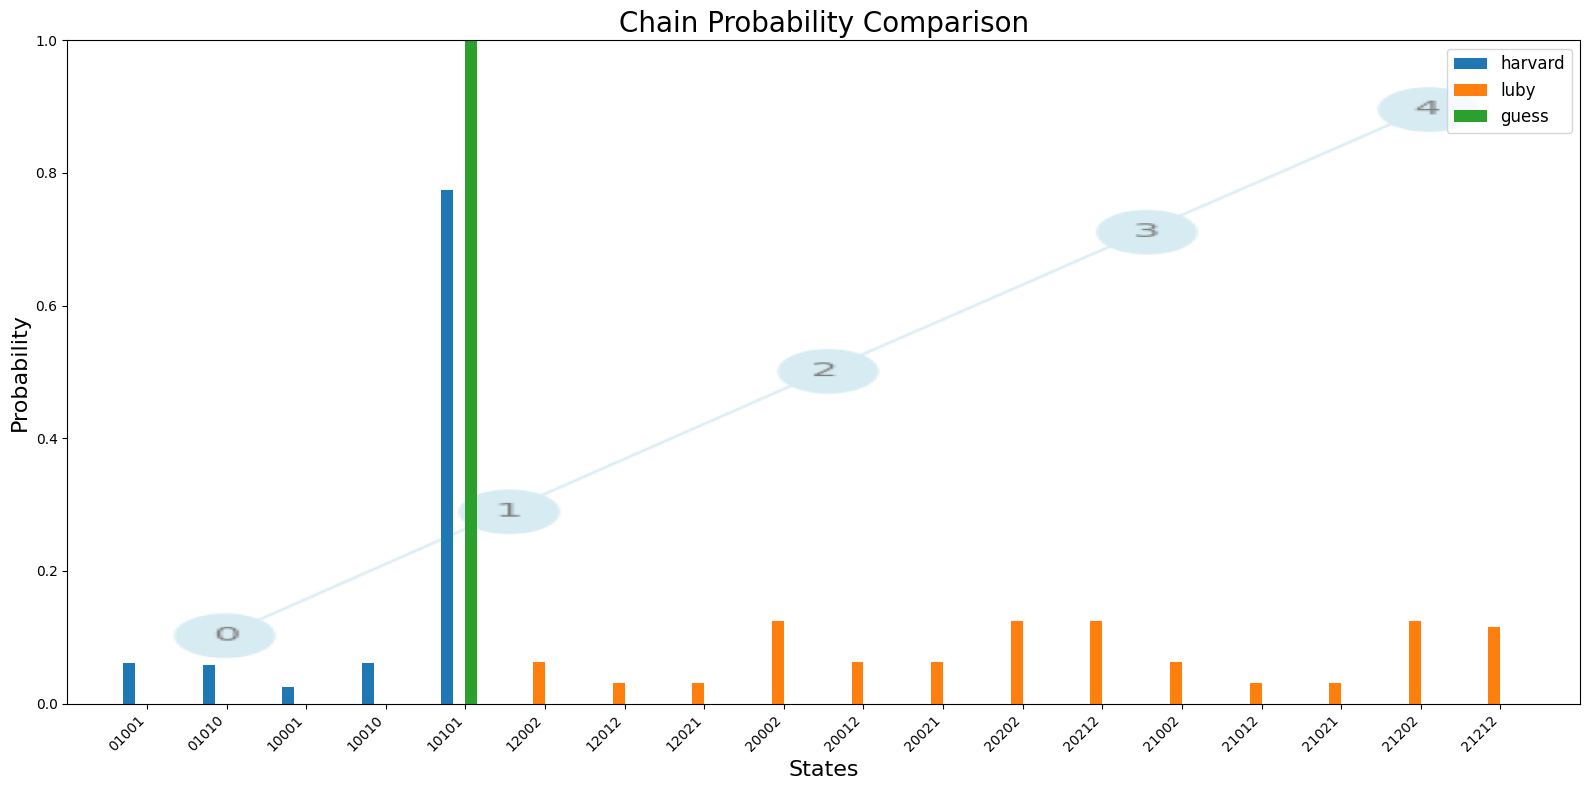

In [8]:
N = 5
init_params = algo.initialize_system_parameters(tau_max=10,vertex_placement = 0.8)
chain_graph = algo.ChainGraph(N)
chain_graph.create_graph()
# Initialize Hamiltonians
harvard_hamiltonian = algo.HarvardHamiltonian(init_params, chain_graph)
luby_hamiltonian = LubyHamiltonian(init_params, chain_graph)
guess_hamiltonian = algo.GuessHamiltonian(init_params, chain_graph,algo.default_guess_function)

# Solve each Hamiltonian
harvard_h_t, harvard_result = harvard_hamiltonian.solve()
luby_h_t, luby_result = luby_hamiltonian.solve()
guess_h_t, guess_result = guess_hamiltonian.solve()

# Consolidate results
# Consolidate results
hamiltonians_out = {
    "harvard": harvard_h_t,
    "luby": luby_h_t,
    "guess": guess_h_t,
}

results_out = {
    "harvard": harvard_result,
    "luby": luby_result,
    "guess": guess_result,
}

algo.plot_probabilities(results_out, N, graph_type="Chain", graph=chain_graph, threshold=0.01, merge_states_flag=True)
algo.plot_probabilities(results_out, N, graph_type="Chain", graph=chain_graph, threshold=0.01, merge_states_flag=False)